In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt
import opendatasets as od
import os
import json

print(tf.__version__)

2.14.0


In [38]:
DATASET_HOST = "https://www.kaggle.com/datasets"
DATASET_DOMAIN = "gpiosenka"
DATASET_NAME = "70-dog-breedsimage-data-set"
ROOT = "./../"
DATA_ROOT = f"{ROOT}/data"
MODEL_ROOT = f"{ROOT}/models"
IMAGE_SIZE = 224
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 10

In [39]:
if not os.path.exists(f"{DATA_ROOT}/{DATASET_NAME}"):
    od.download(f"{DATASET_HOST}/{DATASET_DOMAIN}/{DATASET_NAME}")
    os.rename(DATASET_NAME, f"{DATA_ROOT}/{DATASET_NAME}")

In [40]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    f"{DATA_ROOT}/{DATASET_NAME}/train",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)
val_set = tf.keras.preprocessing.image_dataset_from_directory(
    f"{DATA_ROOT}/{DATASET_NAME}/valid",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    f"{DATA_ROOT}/{DATASET_NAME}/test",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 7946 files belonging to 70 classes.
Found 700 files belonging to 70 classes.
Found 700 files belonging to 70 classes.


['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']
(224, 224, 3)
[60 41 35 41 50 51 37 28 30 12 60 24  3 50 

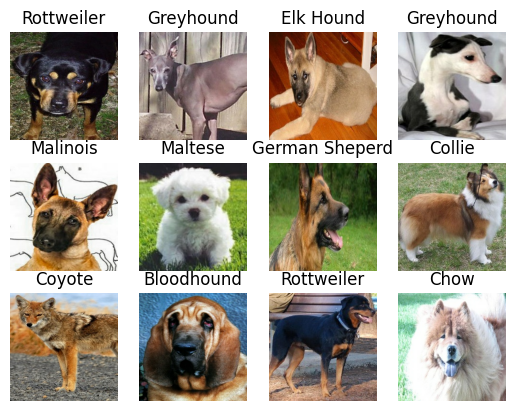

In [41]:
n_classes = len(train_set.class_names)
for image_batch, label_batch in train_set.take(1):
    print(image_batch[0].shape)
    print(label_batch.numpy())

    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.title(train_set.class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [19]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

train_set = train_set.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# val_set = val_set.map(
#     lambda x, y: (data_augmentation(x, training=False), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

# test_set = test_set.map(
#     lambda x, y: (data_augmentation(x, training=False), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1.0 / 255),
    ]
)

In [22]:
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
tf.random.set_seed(42)
model = models.Sequential(
    [
        resize_and_rescale,
        # data_augmentation,
        layers.Conv2D(
            32,
            kernel_size=(3, 3),
            activation="relu",
            padding="same",
            strides=1,
            input_shape=INPUT_SHAPE,
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(
            32, kernel_size=(3, 3), activation="relu", padding="same", strides=1
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(
            32, kernel_size=(3, 3), activation="relu", padding="same", strides=1
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(
            32, kernel_size=(3, 3), activation="relu", padding="same", strides=1
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(
            32, kernel_size=(3, 3), activation="relu", padding="same", strides=1
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(
            32, kernel_size=(3, 3), activation="relu", padding="same", strides=1
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(140, activation="relu"),
        layers.Dense(n_classes, activation="softmax"),
    ],
    name="dog_breed_model",
)

model.build(INPUT_SHAPE)
model.summary()

Model: "dog_breed_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 224, 224, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 112, 112, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 112, 112, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 56, 56, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 56, 56, 32)      

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # optimizer=Adam(learning_rate=1e-3) , RMSprop
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  #
    metrics=["accuracy"],
)

In [48]:
history = model.fit(
    train_set,
    batch_size=BATCH_SIZE,
    validation_data=val_set,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
249/249 [==============================] - 45s 180ms/step - loss: 2.6550 - accuracy: 0.2936 - val_loss: 2.5088 - val_accuracy: 0.3014
Epoch 2/10
249/249 [==============================] - 45s 180ms/step - loss: 2.4497 - accuracy: 0.3365 - val_loss: 2.4803 - val_accuracy: 0.3200
Epoch 3/10
249/249 [==============================] - 45s 180ms/step - loss: 2.2784 - accuracy: 0.3764 - val_loss: 2.4028 - val_accuracy: 0.3343
Epoch 4/10
249/249 [==============================] - 45s 179ms/step - loss: 2.0836 - accuracy: 0.4220 - val_loss: 2.4778 - val_accuracy: 0.3229
Epoch 5/10
249/249 [==============================] - 45s 180ms/step - loss: 1.9490 - accuracy: 0.4519 - val_loss: 2.4220 - val_accuracy: 0.3600
Epoch 6/10
249/249 [==============================] - 45s 180ms/step - loss: 1.7934 - accuracy: 0.4918 - val_loss: 2.3463 - val_accuracy: 0.3729
Epoch 7/10
249/249 [==============================] - 45s 180ms/step - loss: 1.6260 - accuracy: 0.5374 - val_loss: 2.3422 - val_ac

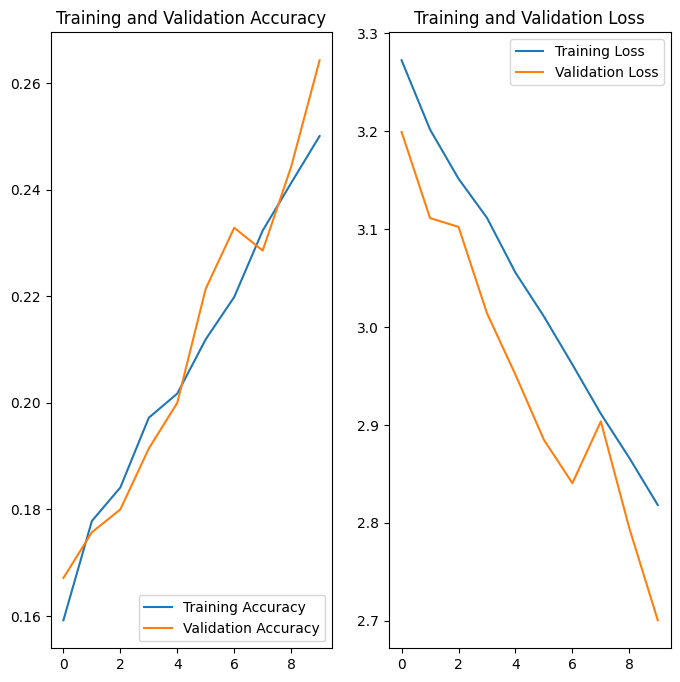

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history["accuracy"], label="Training Accuracy")
plt.plot(range(EPOCHS), history.history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history["loss"], label="Training Loss")
plt.plot(range(EPOCHS), history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [47]:
with open(f"{ROOT}/api/class_names.txt", "w") as f:
    json.dump(train_set.class_names, f)

In [49]:
import os

model_version = max([int(i) for i in os.listdir(MODEL_ROOT) + [0]]) + 1
model.save(f"{MODEL_ROOT}/{model_version}")
model.save(f"{ROOT}/dog_breed_model.keras")

INFO:tensorflow:Assets written to: ./..//models/10/assets


INFO:tensorflow:Assets written to: ./..//models/10/assets


In [34]:
model.evaluate(test_set)

22/22 [==============================] - 1s 51ms/step - loss: 2.7465 - accuracy: 0.2714


[2.7464823722839355, 0.27142858505249023]